# Dependencies

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from torchvision import transforms
from util import save_model, load_model, save_result, load_result
from model import VAE
from preprocess import ClipTransform, ReplaceNaN
from custom_dataset import CustomDataset
from torch.utils.data import DataLoader
from plots import plot_latent, reconstruct, plot_reconstructed, interpolate, interpolate_gif

%load_ext autoreload
%autoreload 2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model

In [2]:
# load the model    
beta = 1.0
vae = VAE(image_channels=1, h_dim=256 * 1 * 1, z_dim=2, beta = beta, device=device)
vae = load_model(vae, model_path='./my_model/vae_beta1.0_epoch1000_batchsize16_lr1e-3.pth')

# Dataset

In [3]:
data_path = './data/MDISC/small_dataset/train_v2d_alpha_cubic_512x512.pkl'
labels_path = './data/MDISC/small_dataset/train_labels.pkl'

width = 512

# transforms.ToTensor assumes input dimensions (H x W x C)
transform=transforms.Compose([transforms.ToTensor(),
                              torch.log,
                              ClipTransform(min_value=-21), #-inf resulted from log 0
                              ReplaceNaN(constant=-21), # NaN resulted from log -ve values
                              transforms.Normalize(mean=[-3.6951], std=[1.3562]), # mean and std determined in `preprocess.ipynb`
                             ])
dataset = CustomDataset(data_path=data_path, labels_path=labels_path, transform=transform)

## Plot latent vectors
Let’s plot the latent vector representations of a few batches of data.

In [4]:
batch_size = 1
shuffle = False
num_workers = 4
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)

array([<Axes: xlabel='lv1', ylabel='lv2'>,
       <Axes: xlabel='lv1', ylabel='lv2'>,
       <Axes: xlabel='rmp', ylabel='Kh'>], dtype=object)

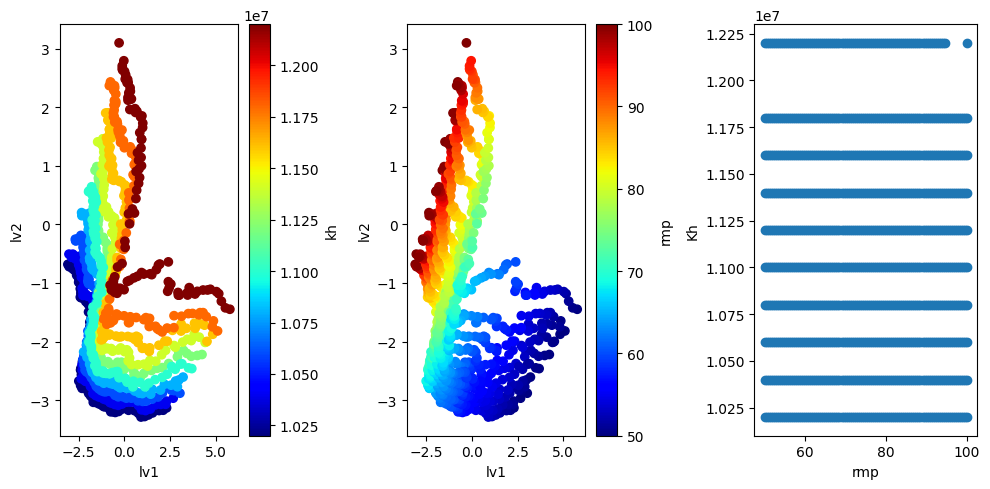

In [5]:
plot_latent(vae, dataloader, output='./output/latent_vectors.jpg')

Ideally, we would like to see an arrangement of colour in the latent space (panels 1 and 2), following the same arrangement as in the 3rd panel. This would indicate that the latent variables really correspond to the parameters 'kh' and 'rmp'.

## Visualizing reconstructions

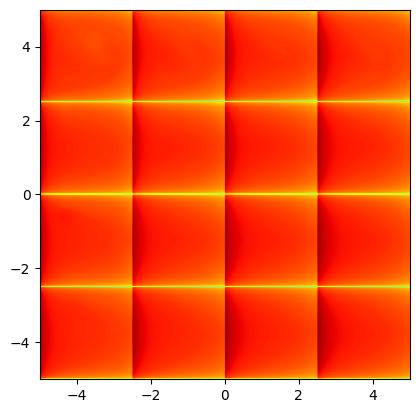

In [8]:
plot_reconstructed(vae, width=512, z0=(-5, 5), z1=(-5, 5), n_img=4)

In [11]:
# load a sample from the dataloader
for x, y in dataloader:
    # Extract the data and labels from the batch
    x = x.to(device).float() # GPU
    y = np.array(y)
    break

# reconstruct sample
x_hat = reconstruct(vae.eval(), x, width)


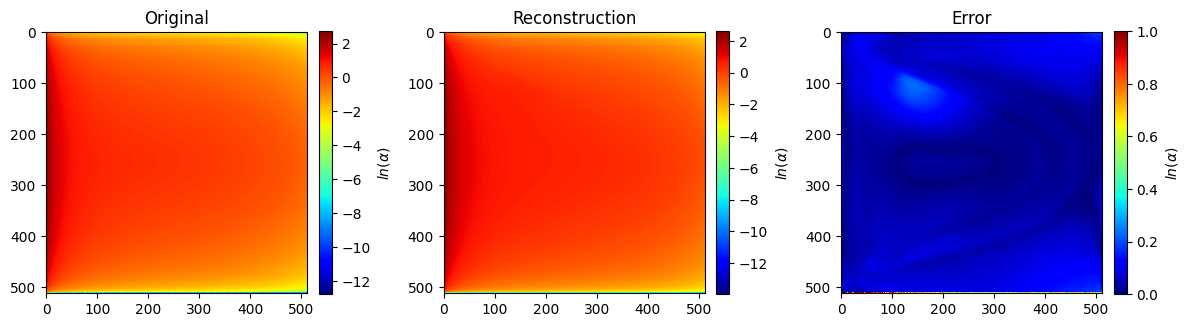

In [16]:
fig, ax = plt.subplots(1,3, figsize=(12,6))
x_orig = x[0].cpu().detach().numpy().squeeze()
err = np.sqrt((x_orig-x_hat)**2)
s1 = ax[0].imshow(x_orig, cmap="jet")
s2 = ax[1].imshow(x_hat, cmap="jet")
s3 = ax[2].imshow(err, cmap='jet', vmin=0, vmax=1)
ax[0].set_title('Original')
ax[1].set_title('Reconstruction')
ax[2].set_title('Error')
plt.colorbar(s1, label=r'$log(\alpha)$', ax=ax[0], fraction=0.046, pad=0.04);
plt.colorbar(s2, label=r'$log(\alpha)$', ax=ax[1], fraction=0.046, pad=0.04);
plt.colorbar(s3, label=r'$log(\alpha)$', ax=ax[2], fraction=0.046, pad=0.04);
plt.tight_layout()

## Visualizing interpolations

In [26]:
batch_size = 128
shuffle = False
num_workers = 4
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)

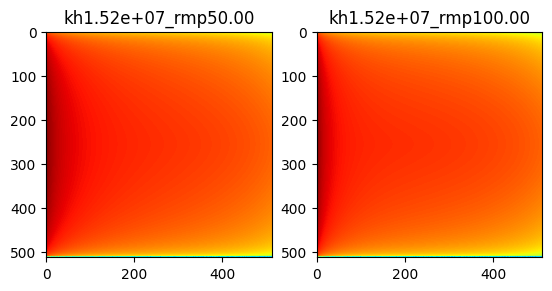

In [31]:
for x,y in dataloader:
    y = np.array(y)
    # find sample corresponding to label y
    x_1 = x[y == 'kh1.02e+07_rmp50.00'][0].unsqueeze(dim=1).to(device).float() 
    x_2 = x[y == 'kh1.02e+07_rmp100.00'][0].unsqueeze(dim=1).to(device).float()
    
    # plot interpolation
    fig, ax = plt.subplots(1,2)
    ax[0].imshow(x_1.cpu().detach().numpy().squeeze(), cmap='jet')
    ax[1].imshow(x_2.cpu().detach().numpy().squeeze(), cmap='jet')
    ax[0].set_title('kh1.02e+07_rmp50.00')
    ax[1].set_title('kh1.02e+07_rmp100.00')
    break

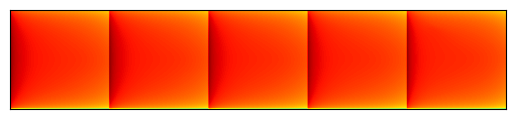

In [32]:
interpolate(vae.eval(), x_1, x_2, width, n_img=5)

In [176]:
interpolate_gif(vae, width, "vae", x_1, x_2)